##### Copyright 2020 The TensorFlow Authors.

In [1]:
from IPython import display

import glob
import imageio
import PIL
import time
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers

2022-01-04 10:47:49.752797: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images))
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(len(test_images))

In [6]:
class CVAE(tfk.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim: int, filters: List[int] = [32, 64], input_shape: Tuple[int, int, int] = (28, 28, 1)):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        enc_convs = [tfkl.Conv2D(filters=f, kernel_size=3, strides=2, activation='relu') for f in filters]
        dec_convs = [tfkl.Conv2DTranspose(filters=f, kernel_size=3, strides=2, activation='relu', padding='same') for f in filters[::-1]]
        self.encoder = tf.keras.Sequential(
            [
                tfkl.InputLayer(input_shape=(28, 28, 1)),
                *enc_convs,
                tfkl.Flatten(),
                # No activation
                tfkl.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tfkl.InputLayer(input_shape=(latent_dim,)),
                tfkl.Dense(units=7*7*32, activation=tf.nn.relu),
                tfkl.Reshape(target_shape=(7, 7, 32)),
                *dec_convs,
                # No activation
                tfkl.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        z = eps * tf.exp(logvar * .5) + mean
        return z, mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
def log_normal_pdf(sample: tf.Tensor, mean: tf.Tensor, logvar: tf.Tensor, raxis: int = 1) -> tf.Tensor:
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def kl_divergence(mean: tf.Tensor, sd: tf.Tensor) -> tf.Tensor:
    return - 0.5 * tf.reduce_sum(
            1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mean) - tf.math.square(sd),
            axis=1)

def compute_loss(model: tfk.Model, 
                 x: tf.Tensor, 
                 loss: str = "cross_entropy", 
                 analytic_kl: bool = False, 
                 beta: float = 1.) -> Tuple[tf.Tensor, ...]:

    # forward pass
    z, mean, logvar = model.encode(x)
    x_logit = model.decode(z)
    
    # compute neg log likelihood
    if loss == "cross_entropy":
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    elif loss == "mse":
        logpx_z = tf.reduce_mean((x - x_logit)**2 / np.prod(x.shape), axis=[1, 2, 3])
        # print(logpx_z)
    # compute kl divergence
    if analytic_kl:
        sd = tf.exp(logvar * .5)
        kl_div = kl_divergence(mean, sd)
    else:
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        kl_div = logpz - logqz_x
    kl_div *= beta
    
    return -tf.reduce_mean(logpx_z + kl_div), logpx_z, kl_div

@tf.function
def train_step(model: tfk.Model, 
               x: tf.Tensor, 
               optimizer: tfk.optimizers.Optimizer, 
               loss: str = "cross_entropy",
               analytic_kl: bool = False,
               beta: float = 1.) -> Tuple[tf.Tensor, ...]:
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        elbo, nll, kl_div = compute_loss(model, x)
    gradients = tape.gradient(elbo, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return elbo, nll, kl_div

In [8]:
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-4
LATENT_DIM = 2
LOSS = "mse" # "cross_entropy"
ANALYTIC_KL = True
BETA = 1.
FILTERS = [32, 64]

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
num_examples_to_generate = 16

In [9]:
model = CVAE(LATENT_DIM, filters=FILTERS)
optimizer = tfk.optimizers.Adam(LR)

In [10]:
def generate_images(model: tfk.Model, test_sample: tf.Tensor) -> None:
    z, mean, logvar = model.encode(test_sample)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -4.49, time elapse for current epoch: 3.98


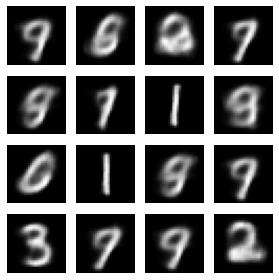

In [12]:
generate_images(model, test_sample)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    for train_x in train_dataset:
        elbo, nll, kl_div = train_step(model, train_x, optimizer, loss=LOSS, analytic_kl=ANALYTIC_KL, beta=BETA)
    end_time = time.time()

    for test_x in test_dataset:
        elbo, nll, kl_div = compute_loss(model, test_x, loss=LOSS, analytic_kl=ANALYTIC_KL, beta=BETA)

    display.clear_output(wait=False)
    print(f'Epoch: {epoch}, Test set ELBO: {elbo.numpy():.2f}, time elapse for current epoch: {end_time - start_time:.2f}')
    generate_images(model, test_sample)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [13]:
from sklearn.manifold import TSNE

def plot_latent_space(model: tfk.Model, test_images: np.ndarray, test_labels: np.ndarray) -> None:
    zs = np.array([model.encode(test_x[None,...,None])[0].numpy()[0].tolist() for test_x in test_images])
    if zs.shape[-1] > 2: # check if latent_dim > 2 -> dimensionality reduction with tsne for plotting purposes
        tsne = TSNE()
        zs = tsne.fit_transform(zs)
    zs = {n: zs[test_labels == n] for n in range(10)}
    for n, zs_n in zs.items():
        plt.scatter(zs_n[:,0], zs_n[:,1], label=n)
    plt.legend()
    plt.show()

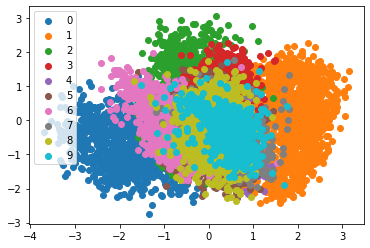

In [14]:
plot_latent_space(model, test_images, test_labels)

In [15]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

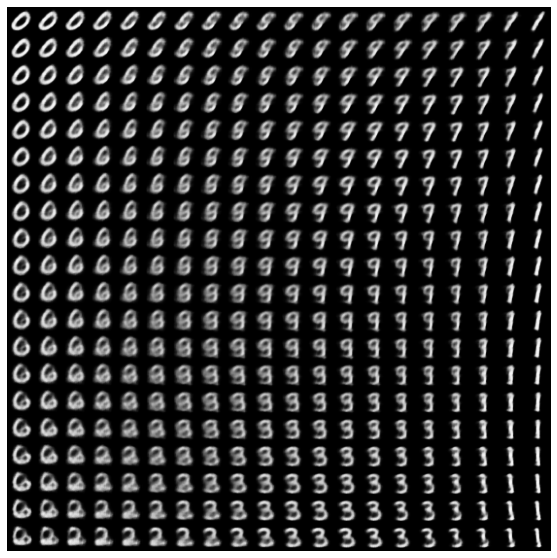

In [16]:
plot_latent_images(model, 20)

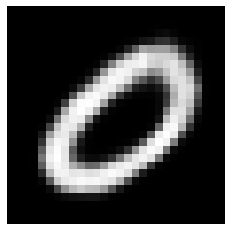

In [17]:
z = np.array([[-2, -2]])
pred = model.decode(z, apply_sigmoid=True)
plt.imshow(pred[0,...,0].numpy(), cmap="gray")
plt.axis('off')
plt.show()